In [1]:
import cleaning
import VoD
import etl
import eda
import viz

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# from IPython.display import display, HTML
# CSS = """
# .output {
#     flex-direction: row;
# }
# """
# HTML('<style>{}</style>'.format(CSS))

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# <span style="color:navy">Introduction</span>

##### Intro to the problem

The problem being investigated is racial/ ethnic disparities in the data collected by the San Diego Police Department during traffic stops. A few studies have addresses this problem, but most significantly a study done by SDSU. The data for the study consisted of “259,569 records generated by SDPD officers following traffic stops occurring between January 1, 2014, and December 31, 2015”. However, the data analyzed only included stops that occurred because of the suspect description, code enforcement effort, etc. This was done to try and limit the analysis to situations where the reason for the discrepancy in the decisions of post- stop outcomes could be attributed to an officer’s use of race/ ethnicity bias.

The result of the SDSU study was mixed, sometimes disparity in traffic stops by race was see and other times it was not. Analysis was done city wide for individual years (2014 and 2015 separately) as well as combined. Additional analysis was done at the division level. The study compared not only the 9 divisions of San Diego, but the 5 divisions located above Interstate 8 against the 4 divisions below. This was done because the Interstate creates a physical socio-economic barrier in San Diego. 

‘Hit rates’ were also investigated, or the percentage of searches that were ‘successful’ (i.e. led to contraband found or and arrest). 

##### Intro to data and data generating process

The data collection was done using “vehicle stop cards”. These recorded the basic driver demographic information: race, gender, age, San Diego residency, date, time, location of stop, and reason for stop. Post stop outcomes are also recorded” issuance of a citation, field interview, search conducted, seizure of property, discovery of contraband, or arrest. There is also an optional space for qualitative descriptions. This study also only used data for stops that were recorded as an equipment or moving violation.


The majority of the studies have been focused on “Who gets pulled over”, “Post- stop outcomes”, “hit rate” (i.e. proportion of is contraband found), and “arrest rate”. This analysis was done using “propensity score matching”; which “matched” drivers of different races to counterparts with similar demographic and stop- based characteristics in an effort to isolate the effect that race/ ethnicity had on post- stop outcomes.


Although this data is appropriate to answer the question at hand, there are several shortcomings. There is some important information not included that would improve the quality of analysis. This vehicle stop cards do not record race/ ethnicity of the officer, specific geo-location of the stop/ search, make, model, vehicle condition, and driver/ passenger demeanor. In other California- wide studies, the results have been scrutinized because the “report lacked details about whether stops occurred in high- or low-crime areas”. The introduction of this specific geo-location could help with this complaint. The vehicle information [not included] has been used in other studies to control data for the confounding factor of economic status. Socio-economic status was one of the causes of racial disparities in the North Carolina study. This information would help distinguish the cause of racial disparities in post stop outcomes; are they a result of differential criminality or something else (“Bad Apple” police, widely shared but individually subtle differences in driver treatment, implicit bias, or Institutional practices).


Several factors have also led SDPD to question the reliability of the data. There is a lot of missing data: 10.6% of citations, 7.9% of field interviews, 4.4% of searches, and 93% of contraband found data. Additionally, some of the search types were unable to be de-aggregated, and therefore making it difficult to assess racial disparities by search type.


Another issue with this data set is using total population as a benchmark to establish rates. The tends to inflate bias for several reasons: the driving population is not equal to the total population age and may be different across races, economic factors can influence who drives (and who takes public transportation), one person can be stopped multiple times, commuters may not be residents, etc.


The column for age is also problematic because it is actually ‘perceived age’ and not actually recorded from looking at licenses. This can be an issue for ages being ‘bunched’ together at the 25 year, 30 year, and other increments of 5 or 10. Also, some races of people are more likely to look younger or older than they are, so the mis-identified and rounding of ages would not even be uniform across races.


Additionally, the data used was filtered based on the “Veil of Darkness” technique. This is based off the assumption that if officers are engaged in racial profiling, they are less likely to be able to identify a driver’s race at nigh than during the day. The issue with this is that vehicle make, year, and model often correlate with race and are still visible at night, which could lead to the test under-estimating the extent of racial profiling. This technique also does not take into effect artificial lighting from street lighting.


Another possible issue with the veil of darkness is ‘bunching’ in the time_stop data. Most people tend to round to the nearest 5, 10 or 30 minutes when recording time (and you can see this phenomenon in the EDA of time_stop). This can make a huge difference in the Veil of Darkness technique since the inter-twilight period is filtered from such a small window of time. Also, driving during different days of the week or even season could be different. For example, someone driving on a Tuesday in warm summer may be very different than a Friday night in a stormy winter. 

##### Review of historical context:

One of the most popular studies on this topic was North Carolina 2002. In this study, a state- wide investigation of traffic stop data occurred, allowing for the analysis of different cities and different levels of disparity. This study spans a larger time period than the SDSU study and has more levels of disparity. One advantage the North Carolina study had was the presence of officer IDs for each traffic stop. This study also looked at "Who is searched" and at stop rates. 

# <span style="color:navy">Exploratory Data Analysis</span>

To explore the different formats of data collected, for this project I look at data from 2017 and 2018 (after the data collection process changed). I decided to compare these two years to be able to see a consecutive year- by- year change. I was specifically interested in seeing the was the new data collection process influenced the results of my analysis. The 2018 data is actualy a combination of both formats. For some of the charts (e.g. outcome distribution) I have seperated 2018 into before and after July 1, 2018 (when RIPA data generation process began) so the plots are more accurate. 

Note: most of the main columns I look at in the preliminary EDA remain the same for the new format.

In [3]:
raw_2017 = pd.read_csv('data/raw/2017_raw.csv')
clean_2017 = pd.read_csv('data/cleaned/2017_clean.csv')

In [4]:
raw_2018 = pd.read_csv('data/raw/2018_raw.csv')
clean_2018 = pd.read_csv('data/cleaned/2018_clean.csv')

#### Data Quality

To assess the quality of the data and justify the cleaning, I looked at the null values and data types. For null values, I looked specifically at age and columns that had to do with 'post stop outcomes'. 

#### 2017

In [5]:
viz.null_dist(raw_2017, ['searched', 'obtained_consent', 'contraband_found', 'property_seized', 'arrested'])

,searched,obtained_consent,contraband_found,property_seized,arrested
% Null,0.18264,0.961949,0.960401,0.96074,0.173323


#### 2018

In [6]:
viz.null_dist(raw_2018, ['result', 'action'])

,result,action
% Null,0.0,0.0


According to the data schema, these columns are conditionally null. i.e. obtained_consent, contraband_found, and property_seized will all be null if no search is conducted. Therefore, the null values are expected so be this high since not everone is searched.

For data types, I looked mostly at which columns were appropiate to map to boolean values. I observed that most of the data types were 'objects' or strings. However, most of these would be better off as numerical (1 or 0) or boolean values for easier analysis. I decided to change to boolean the followign columns:
- service_area, subject_age, sd_resdient, arrested, searched, obtained_consent, contraband_found, property_seized

Other columns I looked more closly at were race, age, and time.

##### Race:

#### 2017

In [7]:
viz.null_dist(raw_2017, ['subject_race'])

,race
% Null,0.001238


#### 2018

In [8]:
viz.null_dist(raw_2018, ['race'])

,race
% Null,0.0


The race columns were missing barely any data for 2017 and 2018. The distribution of the different race codes are shown below:

#### 2017

In [9]:
viz.plot_counts(clean_2017, 'driver_race')

,Counts: driver_race
W,32579
H,26091
B,9799
O,7428
A,3696
F,974
V,467
C,341
I,231
X,126


#### 2018

In [10]:
viz.plot_counts(clean_2018, 'driver_race')

,Counts: driver_race
W,38346
H,24329
B,15367
A,3937
M,1928
O,1681
P,690
N,178
F,173
V,70


#### Observations for Race 

Accuracy Issuss:
- possible misidentifying a subset of people uniformly over time

Precision Issues:
- not a uniform way to identify bi-racial people

Cleaning driver_race was not too difficult. This was becasue the data generating process didn't create many null or obscure values for race. The only difficulty was deciding how precise to make race identification. For example, the different years had different levels of detail for types of 'Asian' races. I decided to keep the most detailed race codes. 

For the 2017 and 2018 data, the distribution of race is as follows:

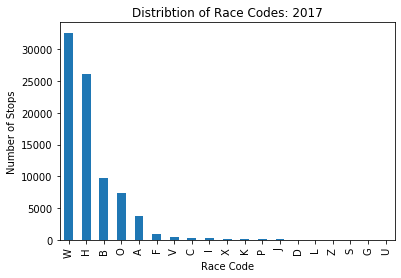

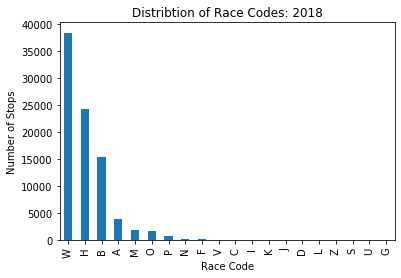

In [11]:
viz.plot_races(clean_2017, 2017)
viz.plot_races(clean_2018, 2018)

For 2017 and 2018, the most abundant races were:
- W: white, H: hispanic, B: black, O: other, A: asian

Because of these races make up the majority of the data, for simplicity I chose for the remainder of my EDA to be narrowed to these categories.

The results of the data exploration of race agrees with my intution of the San Diego racial demographic. Since we are closer to the border, not only are the population of people living here more Hispanic than other areas, but also the driver demographic. Since this 'race' column is the driver_race, the people who live and mexico but commute through San Diego are also reflected in this data.

##### Age:

Before begining eda, it is important to note that the driver age is actually percieved age, by the officer. Because of this, I expected that there would be some accuracy and precision issues with age.

#### 2017

In [12]:
viz.get_non_numeric(raw_2017.subject_age, 'subject_age')

,Counts
perceived_age,
nan,2733
No Age,2172


#### 2018

In [13]:
viz.get_non_numeric(raw_2018.perceived_age, 'perceived_age')

,Counts
perceived_age,


The 2017 the age recorded was pretty clean, it had no non-numeric values. For 2018, the data for age was relatively clean, there were not non-numeric values for age. However, there several values (shown below) that dont really make sense for driving ages. These are most likely a result of human error (while recording or entering data). 

#### 2017

In [14]:
viz.plot_bad_ages(raw_2017, 'subject_age')

,Counts
perceived_age,
nan,2733
0,416
87,32
86,29
88,25
89,21
90,17
93,8
91,7


#### 2018

In [15]:
viz.plot_bad_ages(raw_2018, 'perceived_age')

,Counts
perceived_age,
12,257
10,215
90,102
11,95
9,25
100,16
88,15
86,12
95,11


For cleaning driver age, I decided to filter the values based on the value counts of that age. In other words, it replaced every 'age' that had less than 10 counts with a nan. This got rid of the ages that contained letters, were greater than 92, and were less than 10.

##### Observations for Age:
The graphs above show how 'bunching' is evident in the recorded percieved age. As you can see in both the graphs below, the counts of ages spike every 5 years. This is most likely attributed to human rounding, not because more of the driving population is that age.

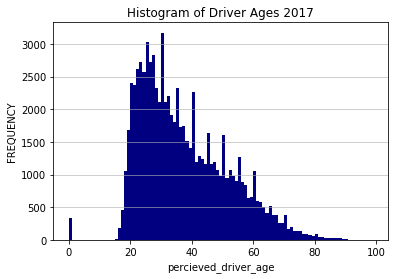

In [16]:
viz.make_hist_age(clean_2017, 'Histogram of Driver Ages 2017', 'percieved_driver_age')

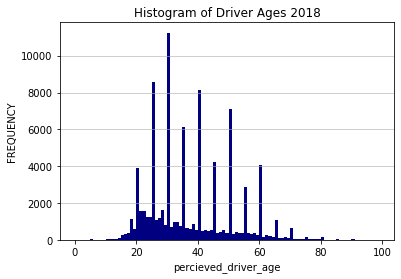

In [17]:
viz.make_hist_age(clean_2018, 'Histogram of Driver Ages 2018', 'percieved_driver_age')

##### Time:

The stop_time column is another value that is human recorded and subject to 'bunching'.

#### Observations for Time

There are precision issues with the time variable because values spikes every hour, half hour, 10 minutes, and 5 minutes (most likely attributed to human rounding). This 'bunching' is especially impactful when dealing with the inter-twilight period because it is so time sensitive

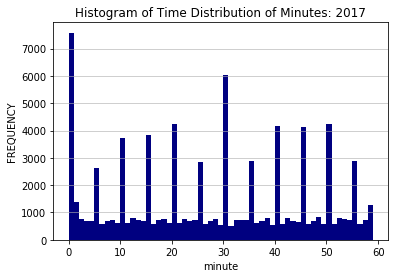

In [18]:
viz.plot_minute(clean_2017)

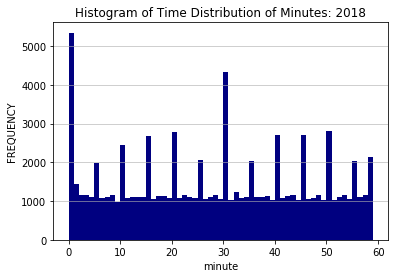

In [19]:
viz.plot_minute(clean_2018)

### Cleaned Data

Once the initial cleaning was done, I chose to assess the relative columns: 'outcome', 'driver_race', and 'percieved_driver_age'

**Outcomes**

As I mentioned earlier, the 2018 data has both formats of outcomes. The, with the majority of the counts being in the RIPA format. This is becuase the pre- RIPA outcomes were only a result of the person being searched (with the exception of 'Arrested'). But the RIPA format had seperate 'result' and 'action' attributes with made up the 'outcome' values. 

#### 2017

In [20]:
pd.DataFrame(clean_2017.outcome.value_counts()) 

,outcome
Not Applicable,78298
Search was conducted,2681
Arrested,868
Property was seized,192
Contraband Found,164


#### 2018

In [21]:
pd.DataFrame(clean_2018.outcome.value_counts())

,outcome
Not Applicable,39488
Citation,24730
Warning (verbal or written),11439
Arrested,10946
Property was seized,169
Search was conducted,72
Contraband Found,2


Overall, the total distributions of outcomes for 2017 and 2018 was as follows:

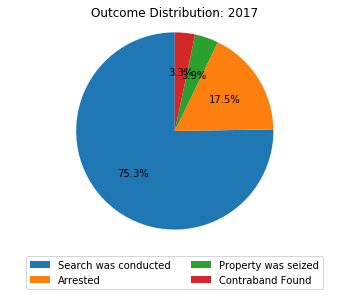

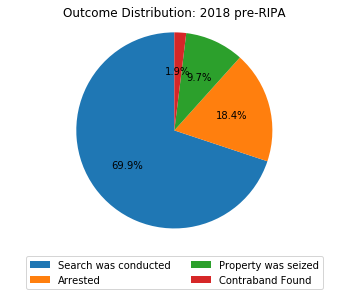

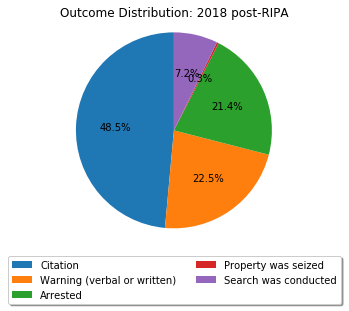

In [22]:
viz.plot_outcomes(clean_2017, 2017)
viz.plot_outcomes(clean_2018, 2018)

Overall, the total distribution (pie chart) of outcomes between 2017 and 2018 looks similiar. I have charted both formats of 2018 so you can compare to 2017 as well as understand the distribution of the new outcome variables. I will go into more detail of the outcome distribution by race in later sections.

# <span style="color:navy">Traffic Stop Analysis</span>

##### Stop Rates

The first analysis perfromed is stop rates by race, using the total population of San Diego from the 2010 census. The stop rates for White, Hispanic, Black and Asian drivers (respectively) in 2017 and 2018 are shown below:

#### 2017

In [23]:
eda.get_stop_rates(clean_2017)

,Stop Rates,Proportion of Population
Race,,
W,0.024919,0.588932
H,0.019956,0.287610
B,0.007495,0.067270
A,0.002827,0.159052


#### 2018

In [24]:
eda.get_stop_rates(clean_2018)

,Stop Rates,Proportion of Population
Race,,
W,0.029330,0.588932
H,0.018609,0.287610
B,0.011754,0.067270
A,0.003011,0.159052


In comparing the 2 years, I chose to focus on the driver races that made up the majority of the stops. Between 2017 and 2018, the stop rates for each race actually decrease. Stop rates in descending order for both years are W, H, B, A. Since these stops rates are calculated with the denominator of total population, it is imperfect. The driving population may be different from the residential population (e.g. commuters), and most likely is, but for the scope of this project it is the denominator chosen.

##### Stop Rates By Service Area

Next, I looked at the stop rates by race in the different service areas.

#### 2017

In [25]:
eda.stop_rates_by_serv(clean_2017)

,W_stop_rate,B_stop_rate,H_stop_rate,A_stop_rate
service_area,,,,
110,0.042941,0.132690,0.057863,0.017982
120,0.070536,0.408051,0.128570,0.030983
230,0.028342,0.074252,0.048540,0.009954
240,0.045315,0.092043,0.069308,0.016730
310,0.100025,0.182174,0.155503,0.081672
320,0.042652,0.185978,0.084211,0.035513
430,0.013671,0.061350,0.033053,0.006688
440,0.014724,0.130239,0.046942,0.019058
510,0.030027,0.108980,0.064604,0.034706


#### 2018

In [26]:
eda.stop_rates_by_serv(clean_2018)

,W_stop_rate,B_stop_rate,H_stop_rate,A_stop_rate
service_area,,,,
110,0.036436,0.159295,0.050477,0.017036
120,0.094616,0.866423,0.170197,0.045518
230,0.019521,0.059475,0.031038,0.006735
240,0.023953,0.064972,0.034805,0.011162
310,0.076356,0.169411,0.114308,0.064836
320,0.031265,0.121150,0.054268,0.023857
430,0.019307,0.048809,0.024542,0.007384
440,0.024233,0.140895,0.039560,0.028307
510,0.055857,0.263847,0.078581,0.038824


From looking at these service areas, some stop rates are similar across races, while others differ greatly. This could be due to service areas capturing different socio- economic statuses or crime rates. To help break down this visual, the service areas that start with a 4, 5, 7, or 8 are located below Interstate 8. Studies have shown that actually acts as a physical and socio-economical barrier between the population.  With that in mind, you can notice that the stop rates for minorities are generally higher in the service areas located below I-8. 

##### Post- Stop Outcomes

As mentioned previously, the 'outcome' column was engineered from several columns (pre-RIPA: 'Arrested', 'Property was seized', 'Search was conducted', and 'Not Applicable', post-RIPA: 'result', 'action'). These engineered outcomes are what I will use to determine the 'rate of successful searches'. 

First I looked at search rates by race:

#### 2017

In [27]:
viz.outcome_dist(clean_2017, ['W', 'H', 'B', 'A'])

Distribution of Outcomes
driver_race outcome                                       
W           Search was conducted                  0.752308
            Arrested                              0.176923
            Contraband Found                      0.039231
            Property was seized                   0.031538
H           Search was conducted                  0.634588
            Arrested                              0.247467
            Property was seized                   0.087554
            Contraband Found                      0.030391
B           Search was conducted                  0.687825
            Arrested                              0.228928
            Contraband Found                      0.062435
            Property was seized                   0.020812
A           Search was conducted                  0.593220
            Arrested                              0.322034
            Contraband Found                      0.084746

#### 2018 pre- RIPA

In [28]:
viz.outcome_dist(clean_2018, ['W', 'H', 'B', 'A'])[0]

Distribution of Outcomes
driver_race outcome                                       
W           Search was conducted                  0.562500
            Arrested                              0.281250
            Property was seized                   0.156250
H           Search was conducted                  0.822222
            Arrested                              0.133333
            Contraband Found                      0.022222
            Property was seized                   0.022222
B           Search was conducted                  0.750000
            Arrested                              0.125000
            Property was seized                   0.125000
A           Property was seized                   0.666667
            Arrested                              0.333333

#### 2018 post- RIPA

In [29]:
viz.outcome_dist(clean_2018, ['W', 'H', 'B', 'A'])[1]

Distribution of Outcomes
driver_race outcome                                              
W           Citation                                     0.543091
            Arrested                                     0.230606
            Warning (verbal or written)                  0.223089
            Property was seized                          0.003215
H           Citation                                     0.539870
            Warning (verbal or written)                  0.244911
            Arrested                                     0.211717
            Property was seized                          0.003502
B           Citation                                     0.400128
            Arrested                                     0.323657
            Warning (verbal or written)                  0.272379
            Property was seized                          0.003836
A           Citation                                     0.587604
            Warning (verbal or written)                  0.274930
            Arrested                                     0.133492
            Property was seized                          0.003973

Similiarly to my EDA of post-stop outcomes, I have calculated both formats of 2018 so you can compare to 2015 as well as understand the distribution of the new outcome variables. For the post-RIPA outcomes in 2018, the distributions are relatively similair across races. There is a slight decrease in the outcomes by race for 2017 to 2018 pre-RIPA (like we saw in the distribution totals in EDA), with the exception of search rate (shown below).

#### 2017

In [30]:
eda.search_rate_by_race(clean_2017)

,search_rate
driver_race,
B,0.094806
H,0.050094
W,0.038307
A,0.013799


#### 2018

In [31]:
eda.search_rate_by_race(clean_2018)

,search_rate
driver_race,
B,0.081994
H,0.060504
W,0.060267
A,0.041148


#### Hit Rate:

Next, I looked at determining if these searches were 'successful', sometimes referred to as the 'hit rate'. For this analysis, I looked at the proportion of stops for each race that (when searched), resulted in one or more of the following outcomes: 'Arrested', 'Property was seized', 'Citation', or 'Warning (verabl or written)'.

Since there are many factors that one could consider when determining if a search was 'successful', I decided to caculate two different 'hit rates'. The first only considers an arrest a successful outcome of a search, the second considers an arrest, property seized, or contraband found. It is important to recognize that these calculation are imperfect, for example not everyone who is arrested is searched or how much contraband counts as 'contraband found'. However, these caveats do not impact the project as a whole greatly. 

#### 2017 Hit Rate 1

In [32]:
eda.hit_rate1(clean_2017)

,hit_rate: Arrested
driver_race,
B,0.022451
H,0.013108
W,0.007060
A,0.005141


#### 2017 Hit Rate 2

In [33]:
eda.hit_rate2(clean_2017)

,"hit_rate: Arrested, Property Seized, Contraband Found"
driver_race,
B,0.030615
H,0.019355
W,0.009884
A,0.006494


The hit rates for arrested are pretty low for each race, which was expected since it is a pretty expreme outcome. However, when  property seized and contraband found were added, the hit rate did not increase very much. This shows that 'successful' searches do not occur that often.

#### 2018 Hit Rate 1

In [34]:
eda.hit_rate1(clean_2018) 

,hit_rate: Arrested
driver_race,
B,0.164834
W,0.127445
H,0.119528
A,0.085598


#### 2018 Hit Rate 2

In [35]:
eda.hit_rate2(clean_2018)

,"hit_rate: Arrested, Property Seized, Contraband Found"
driver_race,
B,0.166916
W,0.129349
H,0.121583
A,0.088646


In 2018, the hit rates for each race increase. However, when adding property seized and contraband found, the hit rates do not increase significantly. Since the actual number of searches did not significantly increase either, the increase in 'successful' searches could be attributed better policing or the intensity of the outcomes (i.e. number of people arrested) increasing.

# <span style="color:navy">Veil of Darkness</span>

The ‘Veil of Darkness’ technique attempts to examine the effect of the drivers’ race/ ethnicity on the likelihood that they will be pulled over. This technique assumes that officers who engage in racial profiling are less likely to see the drivers' race when it is dark out (i.e. low visibility). It also assumes that if a driver's race/ethnicity is a factor in determining who will be stopped, it will be more evident among stops made during the day. Using these assumptions, if stops during dark had a smaller proportion of minority drivers stopped than during light, it would be evidence of racial profiling.

The time period that is used to examine this effect is known as the ‘inter- twilights period’, the time between the earliest and latest civil twilight. In San Diego, for 2015, this was 5:09pm - 8:29pm.

Given the data at hand, I will first explain replicate the veil of darkness technique and then proceed to highlight the shortcommings. For simplicity, I chose to have minority drivers in my analysis refer to driver race of Black (B) or Hispanic (H) and non- minority drivers represent to driver race of White (W).

### Calculation

First I filtered the data based on the intertwilight period and attributed the a is_dark variable to each stop (details in appendix).

In [36]:
IT_2017 = pd.read_csv('data/model/2017_veil.csv')

In [37]:
IT_2018 = pd.read_csv('data/model/2018_veil.csv')

Once I had the filtered intertwilight data, I could assess the stop rates of minorities compared against nonMinorities. As mentioned above, the 'Not Minority' stop rate is the stop rate for White drivers and the Minority stop rate is broken down by Black and Hispanic drivers. The stop rates are also seperated by is_dark, the variable engineered that will allow me to use the Veil of Darkness technique.

#### 2017

In [38]:
VoD.stop_pivot(IT_2017, ['Minority'], ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Not Minority
Minority is_dark                                             
B        dark                0.002786                0.000866
         not_dark            0.003024                0.000969
H        dark                0.001673                0.000866
         not_dark            0.002016                0.000969

#### 2018

In [39]:
VoD.stop_pivot(IT_2018, ['Minority'], ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Not Minority
Minority is_dark                                             
B        dark                0.001967                0.000444
         not_dark            0.001137                0.000238
H        dark                0.000588                0.000444
         not_dark            0.000354                0.000238

In 2017, the stop rates for all drivers are higher during the day. More significantly, the stop rates for minorities increase more during the day than the stop rate for non- minoirity.

However, in 2018, the stop rates for all drivers are higher at night.

It is important to note that the population of San Diego (and the driving population) has more Hispanic people than Black, and this differnece means having a smaller sample size for Black drivers. The small sample size of black drivers, which was made even small in making the intertwilight data, could be influencing the results.

##### Adding the neighborhood of stop, using service area

Next I looked at how the 'neighborhood' general stop location influenced the stop rates. This is important because crime rates or racial distribution may be different in each 'neighborhood'. To determine these 'neighborhoods', I used the service areas in the traffic stop date to determin the divison of the police department they were in. The divisions were North (N), North East (NE), East (E), Mid-City (MS), South (S), South East (SE), Central (C), and West (W). 

#### 2017

In [40]:
VoD.stop_agg(IT_2017, 'div', ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Non-Majority
div Minority is_dark                                             
S   B        dark                0.000091                0.000074
             not_dark            0.000205                0.000077
    H        dark                0.000622                0.000074
             not_dark            0.000668                0.000077
C   B        dark                0.000523                0.000142
             not_dark            0.000478                0.000151
    H        dark                0.000237                0.000142
             not_dark            0.000287                0.000151
N   B        dark                0.000284                0.000199
             not_dark            0.000227                0.000275
    H        dark                0.000112                0.000199
             not_dark            0.000186                0.000275
E   B        dark                0.000455                0.000183
             not_dark            0.000466                0.000160
    H        dark                0.000165                0.000183
             not_dark            0.000170                0.000160
MS  B        dark                0.000421                0.000042
             not_dark            0.000500                0.000057
    H        dark                0.000178                0.000042
             not_dark            0.000197                0.000057
SE  B        dark                0.000659                0.000023
             not_dark            0.000785                0.000008
    H        dark                0.000207                0.000023
             not_dark            0.000301                0.000008
NE  B        dark                0.000136                0.000108
             not_dark            0.000136                0.000135
    H        dark                0.000059                0.000108
             not_dark            0.000074                0.000135
W   B        dark                0.000216                0.000096
             not_dark            0.000227                0.000106
    H        dark                0.000093                0.000096
             not_dark            0.000133                0.000106

#### 2018

In [41]:
VoD.stop_agg(IT_2018, 'div', ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Non-Majority
div Minority is_dark                                             
NE  B        dark                0.000045                0.000030
             not_dark            0.000011                0.000013
    H        dark                0.000019                0.000030
             not_dark            0.000003                0.000013
S   B        dark                0.000045                0.000021
             not_dark            0.000034                0.000008
    H        dark                0.000114                0.000021
             not_dark            0.000045                0.000008
C   B        dark                0.000932                0.000151
             not_dark            0.000443                0.000074
    H        dark                0.000199                0.000151
             not_dark            0.000136                0.000074
E   B        dark                0.000102                0.000052
             not_dark            0.000057                0.000025
    H        dark                0.000051                0.000052
             not_dark            0.000043                0.000025
N   B        dark                0.000171                0.000082
             not_dark            0.000171                0.000074
    H        dark                0.000064                0.000082
             not_dark            0.000032                0.000074
MS  B        dark                0.000239                0.000018
             not_dark            0.000136                0.000012
    H        dark                0.000040                0.000018
             not_dark            0.000032                0.000012
W   B        dark                0.000148                0.000075
             not_dark            0.000091                0.000026
    H        dark                0.000032                0.000075
             not_dark            0.000021                0.000026
SE  B        dark                0.000284                0.000016
             not_dark            0.000193                0.000006
    H        dark                0.000069                0.000016
             not_dark            0.000043                0.000006

The results on this level of granualarity are mixed, some stop rates are higher when its dark others are not. 

Similiarly to how the service areas (mentioned in stop-rate analysis) can be divided by Interstate 8, these resions are also seperatable. N, NW, W, E, and NE are all division located above I8 and the others lay below (see table below).

#### 2017

In [42]:
VoD.stop_agg(IT_2017, 'above_8', ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Non-Majority
above_8 Minority is_dark                                             
0       B        dark                0.001694                0.000281
                 not_dark            0.001967                0.000292
        H        dark                0.001245                0.000281
                 not_dark            0.001452                0.000292
1       B        dark                0.001092                0.000586
                 not_dark            0.001057                0.000677
        H        dark                0.000428                0.000586
                 not_dark            0.000564                0.000677

#### 2018

In [43]:
VoD.stop_agg(IT_2018, 'above_8', ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Non-Majority
above_8 Minority is_dark                                             
1       B        dark                0.000466                0.000239
                 not_dark            0.000330                0.000138
        H        dark                0.000165                0.000239
                 not_dark            0.000098                0.000138
0       B        dark                0.001501                0.000205
                 not_dark            0.000807                0.000100
        H        dark                0.000423                0.000205
                 not_dark            0.000255                0.000100

In 2017, all of the stop rates for minorities are higher when its light out and  increase by more than what the non- minority stop rates increase by. Additionally, the stop rates for minorities when its dark is larger below I8. 

However, in 2018, the result is more mixed.

### Analysis and Shortcomings:

The findings using the Veil of Darkness technique showed mixed results as far as finding evidence to support racial profiling. However, reasons for such differences, or lack thereof, could be attributed to other confounders, not race. 

What may be causing these differences?
- Difference in age
- Difference in driving day of week or time of year
- Differential criminality
- Social and economic disadvantages
- “Bad Apple” police
- Widely shared but individually subtle differences in how white and majority drivers are treated following a traffic stop
- Implicit bias, consequence of years of exposure to associations in the environment 
- Institutional practices which lead to radical differences in outcomes

**Idea 1: Driver age 25 and under driving more recklessly & more suspectable to criminological behavior**

In [44]:
df2017 = VoD.filter_y(IT_2017)
df2018 = VoD.filter_y(IT_2018)

#### 2017

In [45]:
VoD.stop_pivot(df2017, ['Minority'], ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Not Minority
Minority is_dark                                             
B        dark                0.000671                0.000225
         not_dark            0.000625                0.000174
H        dark                0.000468                0.000225
         not_dark            0.000500                0.000174

#### 2018

In [46]:
VoD.stop_pivot(df2018, ['Minority'], ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Not Minority
Minority is_dark                                             
B        dark                0.000307                0.000060
         not_dark            0.000136                0.000038
H        dark                0.000128                0.000060
         not_dark            0.000045                0.000038

The stop rates for the 'younger' population are actually higher for all aggregates over both years. This agrees with the idea that younger drivers are stopped more often. However, we see the same overall result as the origional table, stop rates being higher when its dark (with the exception of Hispanic drivers in 2017).

##### Idea 2: the driving population changes based on day of week 

This idea mostly refers to the driving population of people during weekdays and weekends. The 'day' values represent the days Monday - Sunday as 0-6. 

#### 2017

In [47]:
VoD.stop_agg(IT_2017, 'day', ['B', 'H'], 'W').sort_values(by='day')

Stop Rate Minority  Stop Rate Non-Majority
day Minority is_dark                                             
0   B        dark                0.000398                0.000104
             not_dark            0.000387                0.000152
    H        dark                0.000314                0.000104
             not_dark            0.000311                0.000152
1   H        dark                0.000237                0.000106
    B        dark                0.000432                0.000106
             not_dark            0.000421                0.000130
    H        not_dark            0.000285                0.000130
2   H        not_dark            0.000226                0.000118
             dark                0.000207                0.000113
    B        dark                0.000352                0.000113
             not_dark            0.000478                0.000118
3   B        dark                0.000512                0.000140
             not_dark            0.000557                0.000182
    H        dark                0.000266                0.000140
             not_dark            0.000343                0.000182
4   H        not_dark            0.000388                0.000126
             dark                0.000247                0.000170
    B        dark                0.000500                0.000170
             not_dark            0.000409                0.000126
5   B        dark                0.000375                0.000131
             not_dark            0.000398                0.000155
    H        not_dark            0.000245                0.000155
             dark                0.000202                0.000131
6   H        not_dark            0.000218                0.000106
             dark                0.000199                0.000101
    B        not_dark            0.000375                0.000106
             dark                0.000216                0.000101

#### 2018

In [48]:
VoD.stop_agg(IT_2018, 'day', ['B', 'H'], 'W').sort_values(by='day')

Stop Rate Minority  Stop Rate Non-Majority
day Minority is_dark                                             
0   H        not_dark            0.000053                0.000030
             dark                0.000064                0.000049
    B        not_dark            0.000159                0.000030
             dark                0.000250                0.000049
1   H        not_dark            0.000037                0.000038
    B        not_dark            0.000171                0.000038
             dark                0.000318                0.000071
    H        dark                0.000101                0.000071
2   B        dark                0.000364                0.000074
             not_dark            0.000239                0.000040
    H        dark                0.000098                0.000074
             not_dark            0.000077                0.000040
3   B        dark                0.000318                0.000070
    H        not_dark            0.000072                0.000038
    B        not_dark            0.000148                0.000038
    H        dark                0.000101                0.000070
4   B        not_dark            0.000227                0.000042
    H        dark                0.000098                0.000074
    B        dark                0.000273                0.000074
    H        not_dark            0.000043                0.000042
5   B        dark                0.000250                0.000060
    H        not_dark            0.000027                0.000022
             dark                0.000064                0.000060
    B        not_dark            0.000125                0.000022
6   B        dark                0.000193                0.000045
             not_dark            0.000068                0.000029
    H        dark                0.000061                0.000045
             not_dark            0.000045                0.000029

The results on this level of granualarity are also mixed, some stop rates are higher when its dark others are not. If you focus on the Weekends (days 5 and 6), which some would say is more likely for reckless driving, the stop rates do not necessarliy increase. We can then say the day of the week does not significantly affect stop rates.

##### Idea 3: the driving population changes based on day of season

This idea is similiar to the 'day' anslysis above. The goal is to see if time of year (which can have differences in weather, if tourists are there, etc) affect stop rates significantly.

#### 2017

In [49]:
VoD.stop_agg(IT_2017, 'Season', ['B', 'H'], 'W').sort_values(by='Season')

Stop Rate Minority  Stop Rate Non-Majority
Season Minority is_dark                                             
Fall   B        dark                0.000796                0.000207
                not_dark            0.000659                0.000227
       H        dark                0.000487                0.000207
                not_dark            0.000402                0.000227
Spring B        dark                0.000944                0.000281
                not_dark            0.001205                0.000317
       H        dark                0.000452                0.000281
                not_dark            0.000699                0.000317
Summer B        dark                0.000284                0.000126
                not_dark            0.000932                0.000345
       H        dark                0.000149                0.000126
                not_dark            0.000660                0.000345
Winter B        dark                0.000762                0.000253
                not_dark            0.000227                0.000079
       H        dark                0.000585                0.000253
                not_dark            0.000255                0.000079

#### 2018

In [50]:
VoD.stop_agg(IT_2018, 'Season', ['B', 'H'], 'W').sort_values(by='Season')

Stop Rate Minority  Stop Rate Non-Majority
Season Minority is_dark                                             
Fall   B        dark                0.001342                0.000278
                not_dark            0.000659                0.000129
       H        dark                0.000378                0.000278
                not_dark            0.000197                0.000129
Spring B        dark                0.000011                0.000010
                not_dark            0.000000                0.000016
       H        dark                0.000011                0.000010
                not_dark            0.000024                0.000016
Summer B        dark                0.000114                0.000025
                not_dark            0.000466                0.000088
       H        dark                0.000040                0.000025
                not_dark            0.000130                0.000088
Winter B        dark                0.000500                0.000131
                not_dark            0.000011                0.000005
       H        dark                0.000160                0.000131
                not_dark            0.000003                0.000005

For 2017, Black drivers are stopped more when its dark in Spring and Hispanic drivers are most likely to be stopped when its dark in the winter. However, White drivers are most likely to be stopped in the Summer when its not dark. 

In 2018, Black drivers are most likely to be stopped in the Fall when it is dark while Hispanic drivers are most likely to be stopped in the Fall when it is dark. The seasonal differences for 2018 were not as prevalent.

Overall, there was not a significant difference in aggregating by season for the stop rates comparing when its dark. 

#### Idea 4: the intertwilight period is not strick enough for determining if its dark out

This idea will also help control for bunching in the time data that has been rounded down. By adding more of a buffer, the dataset does get smaller but it whether is is dark or light will be more certain. I adjusted the 'intertwilight' to start 45 later and end 45 minutes sooner.

In [51]:
n2017 = VoD.add_adjusted_dark(IT_2017, 45)
n2018 = VoD.add_adjusted_dark(IT_2018, 45)

#### 2017

In [52]:
VoD.stop_pivot(n2017, ['Minority'], ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Not Minority
Minority is_dark                                             
B        dark                0.002786                0.000862
         not_dark            0.003024                0.000973
H        dark                0.001657                0.000862
         not_dark            0.002032                0.000973

#### 2018

In [53]:
VoD.stop_pivot(n2018, ['Minority'], ['B', 'H'], 'W')

Stop Rate Minority  Stop Rate Not Minority
Minority is_dark                                             
B        dark                0.001967                0.000442
         not_dark            0.001137                0.000240
H        dark                0.000582                0.000442
         not_dark            0.000359                0.000240

Adding more of a buffer to the intertwilight period actually didnt change the stop rates at all. Adding an even larger buffer may narrow down the sample size to small.

##### Interpretation:

While we already addressed the imperfections of using total population as a denominator for stop rates, it is also important to address the possible issues with the intertwilight period. 

Examples of issues with the intertwilight period data include:
- Data consisting of people driving back from work (9-5 jobs), may drive differently
- Police may treat traffic during “rush hour” differently than during the rest of the day
- Using only data with stop_cause = Equipment violations may be not enough data (equipment violations may be less likely to be observed during rush hour)
    - Equipment violations like 'Tail light is out' may almost never be seen during the day
-	Vehicle make, year, and model often correlate with race and are still visible at night, which could lead to the test under-estimating the extent of racial profiling
-	The influence of artificial lighting is not accounted for

Before making any causal assumptions, it is important understand that this technique is not necessarily comparable under the context of other hours of the day (i.e. it is not necessarily a representative sample). That beind said, the majority of the analysis showed that stop rates did not differ during the day and at night, and when they did it was evident in the 2017 data.

# <span style="color:navy">Conclusion</span>

Findings: Traffic Stops
    
In 2017, the stop rates in descending order highest for White, Hispanic, Black, then Asian drivers. In 2018, the order was the same. There is an increase in the stop rates for White and Black drivers but not for Hispanic or Asian drivers. Stop rates by service area showed mixed results, no meaningful differences were evident in the stop rates.

Findings: Post Stop Outcomes

For the search rates by race, there were slight differences. In 2017, the search rates in decreasing order were Black, Hispanic, White, and Asian drivers. For 2018, the order was the same. There higher search rate for Hispanic, White, and Asian drivers but a lower search rate for Black drivers in 2018.

Findings: Hit Rates

For hit rates,  the hit rate using just Arrested and the hit rate using the other outcomes produced similar results for both 2017 and 2018. In descending order the hit rates were also Black, Hispanic, White, and Asian drivers.

Findings: Veil of Darkness

In 2017, the stop rate for Black, Hispanic, and White drivers were higher when it was light. For 2018, all the stop rates when it was light.
Separating traffic stops by location (above_8 and below_8), for 2017 all stop rates for Black and Hispanic drivers were higher when it was light but stop rates for White drivers were not. Additionally, the stop rates for minorities above I8 were much lower than stop rates below I8. For 2018, the results were mixed. 

When I filtered the data to be drivers under the age of 25,  the stop rates themselves increased but as a whole. No meaningful differences were evident in the stop rates.

Similarly, when grouping the data by day of week or season,  the results were mixed and there was not a significant difference in the stop rates.
Additionally, narrowing the inter-twilight period to try and control for lighting more did not affect the results.


In sum:
We find statistically significant and meaningful differences in the post-stop treatment of Black and Hispanic drivers compared to White drivers	across several post stop outcomes. In 2017, the search rate for Black and Hispanic drivers (0.094806 and 0.050094 respectively) are much higher than the search rate for White drivers (0.038307). And similarly for 2018, 0.081994 and 0.060504 for Black and Hispanic drivers  and 0.060267 for White drivers. Although the hit rates were higher for Black and Hispanic driver, it was not by a large amount. 

# <span style="color:navy">Appendix</span>

#### Appendix 1: Data Cleaning Justification:

The major cleaning was mostly done on the age column. The remainder of the cleaning performed was done to make the format of the pre- 2018 data match the post- 2018 data. There were differences in the possible values for gender/ sex and race for the different years that had to be mapped and renammed. The beats in the post- 2018 data were mapped to the service areas accordingly. Several columns were also combined to create and 'outcome' variable for each year. The possible values I decided to create were: 'Arrested', 'Property was seized', 'Search of property was conducted', and 'Not Applicable'. The remainder of the possible outcomes made up a small amout of the data but I didnt drop them (just labeled as 'Not Applicable') becasue I did not want lose the data. As a result, this cleaning did not affect the analysis greatly. This is because my 'outcome' column I will later use to determind if a search is 'successful', and the 'Not Applicable' values will not be used in that analysis.

In pre- 2018, I used to following columns to create outcome: ‘Arrested’, ‘Property_Seized’, and ‘Searched’ 

In post- 2018, I filtered the ‘action’ and ‘result’ columns to create outcome. 

#### Appendix 2: Building the intertwilight data

The intertwilight data was filtered based on wheter or not the stop_time ws between the earliest end of civil twilight (5:09pm) and the latest (8:29pm). From there, I determined whether it was dark or not by using the API fro timeanddate.com and scrapping the appropiate year of data. I used this data to create an is_dark variable for every stop. I also filtered the stop reason, only including stops that occurred because of the suspect description, code enforcement effort, etc. This was done to try and limit the analysis to situations where the reason for the discrepancy in the decisions of post- stop outcomes could be attributed to an officer’s use of race/ ethnicity bias. I additionally added variables like 'season' and 'neighborhood' to assist with analysis.